cell 1 buat import

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from collections import defaultdict
import joblib
import glob
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings

cell 2, disini buat nge apply greyscale ama segmentasiin pake ostu

In [2]:
def preprocess(img, use_blur=False):  # Changed default to False
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
    if use_blur:
        gray = cv2.GaussianBlur(gray, (7, 7), 0)
    return gray

def segment(img_gray, invert_mask=True):
    thresh1 = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    _, thresh2 = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    combined = cv2.bitwise_and(thresh1, thresh2)

    kernel = np.ones((3, 3), np.uint8)
    closed = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

    if invert_mask:
        opened = cv2.bitwise_not(opened)

    return combined, closed, opened

def apply_mask(img, mask):
    return cv2.bitwise_and(img, img, mask=mask)

cell 3 baut extract bentuk dari hasil segmentasi sebelumnyha pake hu_momoents, warna pake hsv, ama texture pake glcm, berdasarkan yang udah kita buat di paper

In [3]:
def plot_hsv_histogram(hsv_masked):
    h, s, v = cv2.split(hsv_masked)
    h = h[h > 0]
    s = s[s > 0]
    v = v[v > 0]

    plt.subplot(3, 1, 1)
    plt.hist(h.ravel(), bins=180, color='r')
    plt.title("Hue Distribution")

    plt.subplot(3, 1, 2)
    plt.hist(s.ravel(), bins=256, color='g')
    plt.title("Saturation Distribution")

    plt.subplot(3, 1, 3)
    plt.hist(v.ravel(), bins=256, color='b')
    plt.title("Value Distribution")

def prepare_texture_image(gray, mask):
    texture_masked = apply_mask(gray, mask)
    return texture_masked

cell 3.1 buat definisiin hasil segmentasi, extract warna, dan texture

In [4]:
image_paths = glob.glob("coba*.jpg")
if not image_paths:
    print("Tidak ditemukan file yang diawali dengan nama 'coba'.")
else:
    image_path = image_paths[0]
    img = cv2.imread(image_path)
    resized = cv2.resize(img, (200, 200))

    gray_blur = preprocess(resized, use_blur=True)  #pake blur buat segmentasi
    gray_no_blur = preprocess(resized, use_blur=False)  #pake blur buat di compare segmentasinya

    otsu1, closed_blur, opened_blur = segment(gray_blur)
    otsu2, closed_noblur, opened_noblur = segment(gray_no_blur)

    hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)
    hsv_masked = apply_mask(hsv, opened_blur)  #masking pake segmentasi yg di blur

    texture_img = prepare_texture_image(gray_no_blur, opened_blur)  #pake yg blur
    glcm = graycomatrix(texture_img, distances=[1], angles=[0],
                        levels=256, symmetric=True, normed=True)
    glcm_vis = glcm[:, :, 0, 0]
    glcm_vis_norm = cv2.normalize(glcm_vis, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")

cell 3.2 buat plotting segmentasi

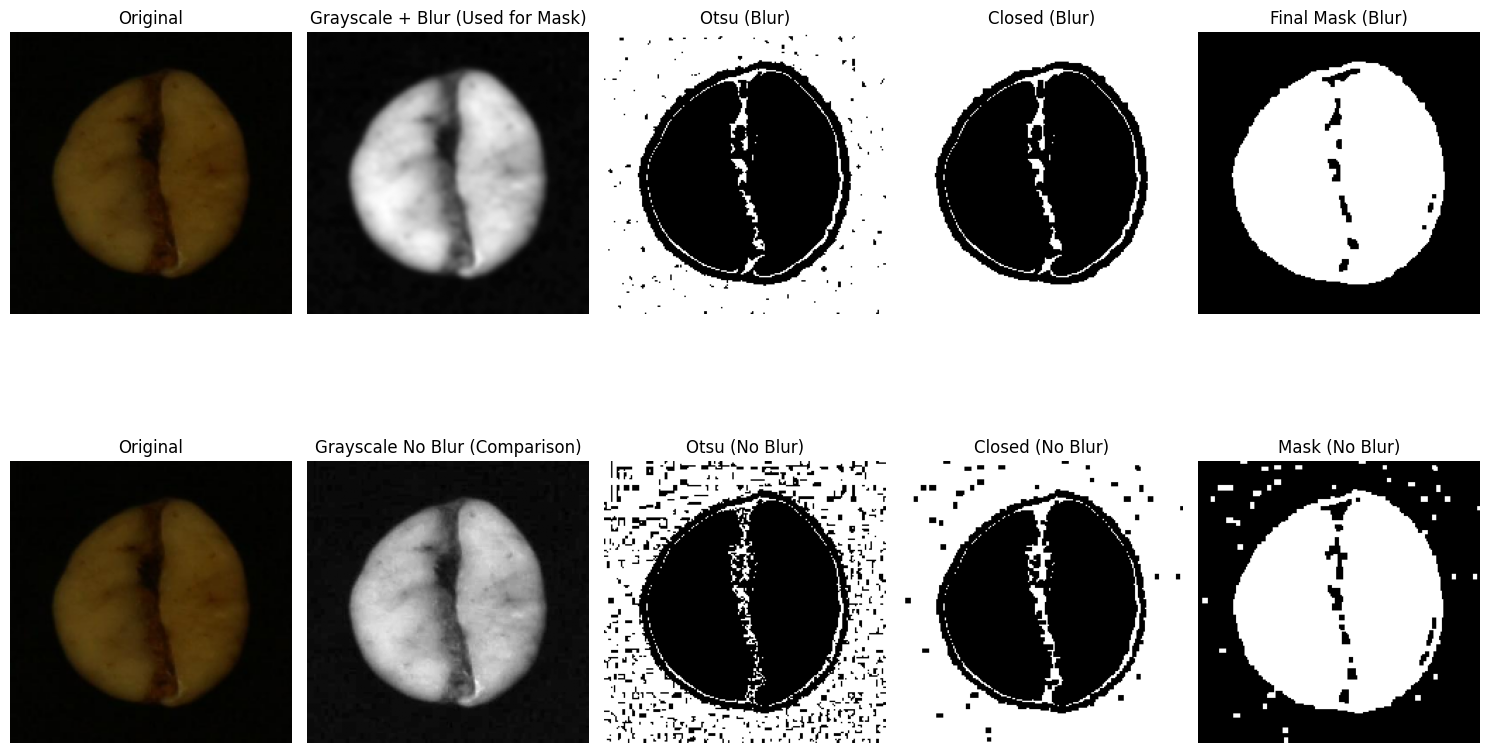

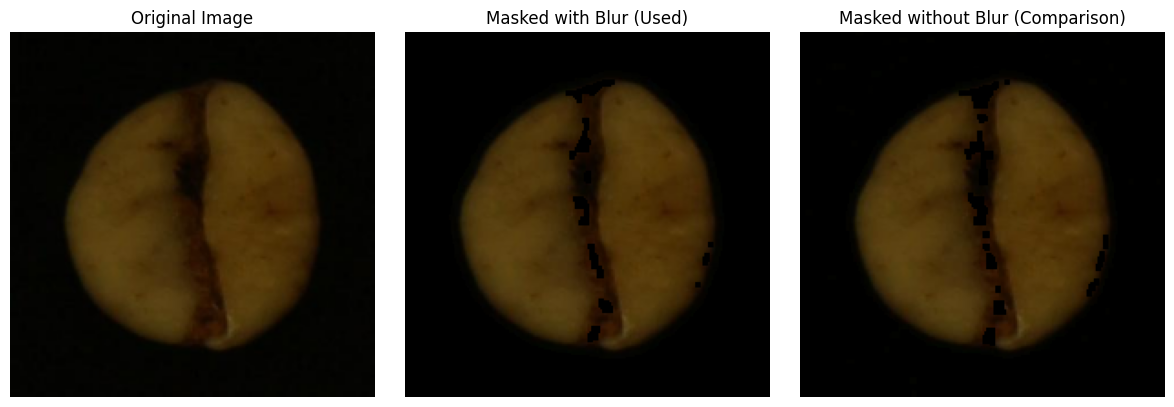

In [5]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 5, 1)
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(2, 5, 2)
plt.imshow(gray_blur, cmap='gray')
plt.title("Grayscale + Blur (Used for Mask)")
plt.axis("off")

plt.subplot(2, 5, 3)
plt.imshow(otsu1, cmap='gray')
plt.title("Otsu (Blur)")
plt.axis("off")

plt.subplot(2, 5, 4)
plt.imshow(closed_blur, cmap='gray')
plt.title("Closed (Blur)")
plt.axis("off")

plt.subplot(2, 5, 5)
plt.imshow(opened_blur, cmap='gray')
plt.title("Final Mask (Blur)")
plt.axis("off")

plt.subplot(2, 5, 6)
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(2, 5, 7)
plt.imshow(gray_no_blur, cmap='gray')
plt.title("Grayscale No Blur (Comparison)")
plt.axis("off")

plt.subplot(2, 5, 8)
plt.imshow(otsu2, cmap='gray')
plt.title("Otsu (No Blur)")
plt.axis("off")

plt.subplot(2, 5, 9)
plt.imshow(closed_noblur, cmap='gray')
plt.title("Closed (No Blur)")
plt.axis("off")

plt.subplot(2, 5, 10)
plt.imshow(opened_noblur, cmap='gray')
plt.title("Mask (No Blur)")
plt.axis("off")

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
masked_with_blur = apply_mask(resized, opened_blur)
plt.imshow(cv2.cvtColor(masked_with_blur, cv2.COLOR_BGR2RGB))
plt.title("Masked with Blur (Used)")
plt.axis("off")

plt.subplot(1, 3, 3)
masked_without_blur = apply_mask(resized, opened_noblur)
plt.imshow(cv2.cvtColor(masked_without_blur, cv2.COLOR_BGR2RGB))
plt.title("Masked without Blur (Comparison)")
plt.axis("off")

plt.tight_layout()
plt.show()

cell 3.3 buat plotting extraksi warna

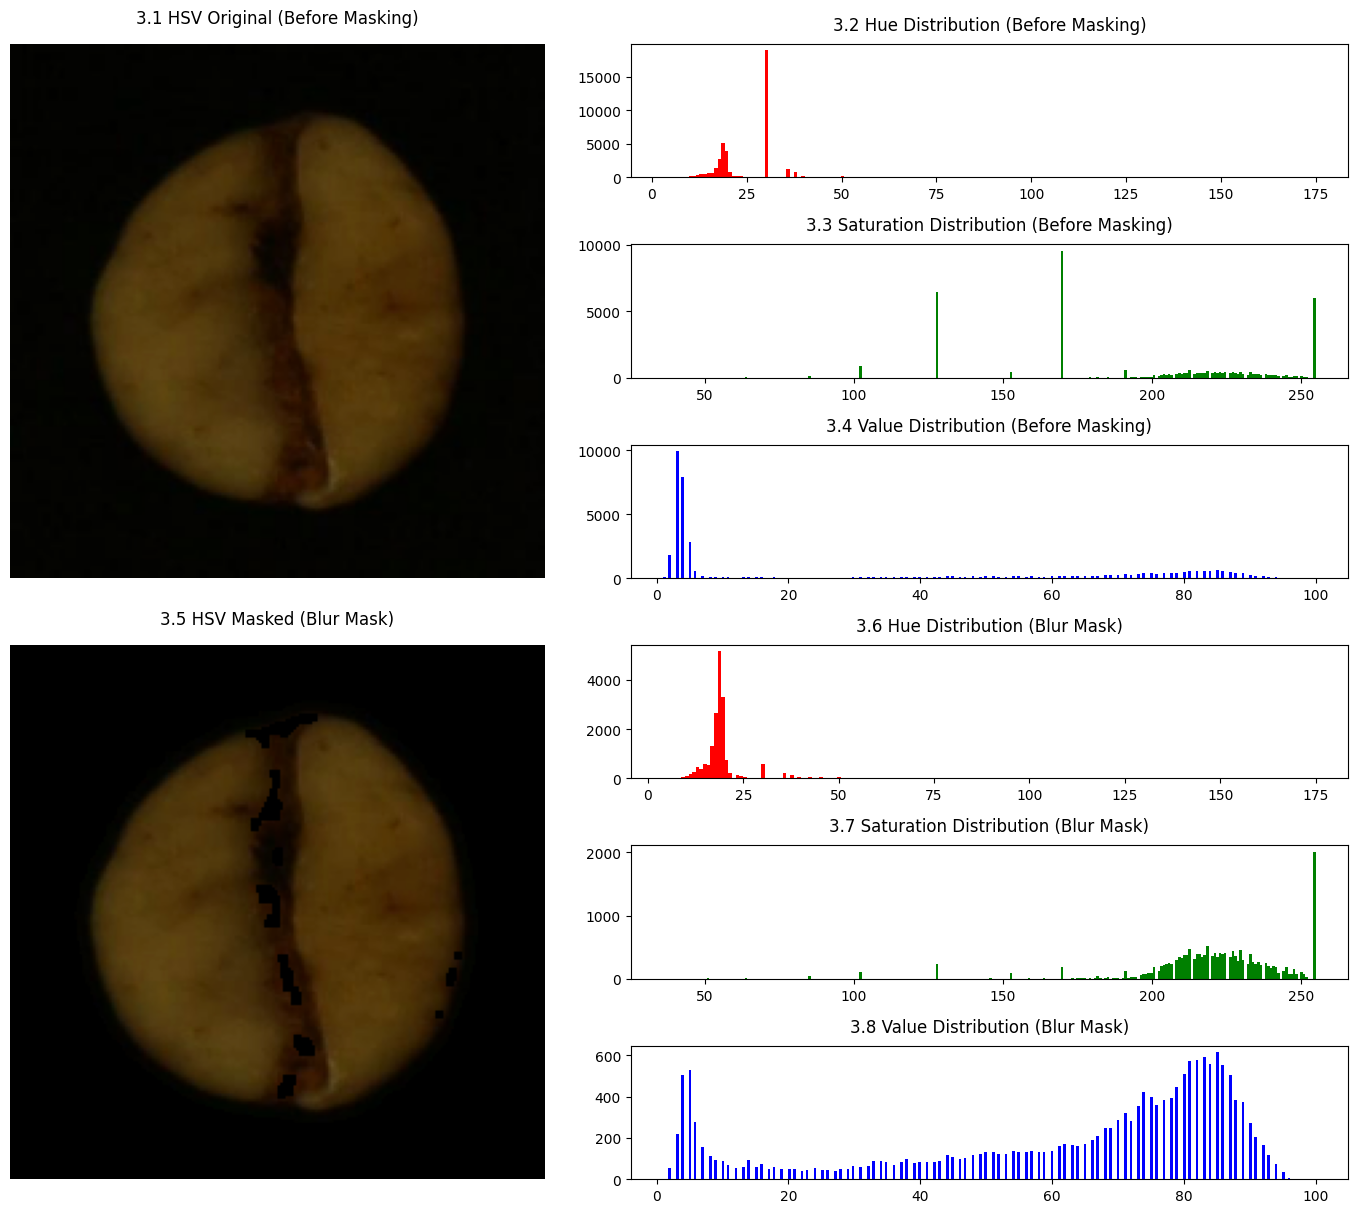

In [6]:
hsv = cv2.cvtColor(resized, cv2.COLOR_BGR2HSV)
hsv_masked = apply_mask(hsv, opened_blur)  #masking pake segmeentasi yg di blur dulu

h1, s1, v1 = cv2.split(hsv)
h1 = h1[h1 > 0]
s1 = s1[s1 > 0]
v1 = v1[v1 > 0]

h2, s2, v2 = cv2.split(hsv_masked)
h2 = h2[h2 > 0]
s2 = s2[s2 > 0]
v2 = v2[v2 > 0]

fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1.2], height_ratios=[1, 1])

ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
ax0.set_title("3.1 HSV Original (Before Masking)", pad=15)
ax0.axis("off")

gs_hist1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0, 1], hspace=0.5)
ax1 = fig.add_subplot(gs_hist1[0])
ax2 = fig.add_subplot(gs_hist1[1])
ax3 = fig.add_subplot(gs_hist1[2])

ax1.hist(h1.ravel(), bins=180, color='red')
ax1.set_title("3.2 Hue Distribution (Before Masking)", pad=10)

ax2.hist(s1.ravel(), bins=256, color='green')
ax2.set_title("3.3 Saturation Distribution (Before Masking)", pad=10)

ax3.hist(v1.ravel(), bins=256, color='blue')
ax3.set_title("3.4 Value Distribution (Before Masking)", pad=10)

ax4 = fig.add_subplot(gs[1, 0])
ax4.imshow(cv2.cvtColor(hsv_masked, cv2.COLOR_HSV2RGB))
ax4.set_title("3.5 HSV Masked (Blur Mask)", pad=15)
ax4.axis("off")

gs_hist2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[1, 1], hspace=0.5)
ax5 = fig.add_subplot(gs_hist2[0])
ax6 = fig.add_subplot(gs_hist2[1])
ax7 = fig.add_subplot(gs_hist2[2])

ax5.hist(h2.ravel(), bins=180, color='red')
ax5.set_title("3.6 Hue Distribution (Blur Mask)", pad=10)

ax6.hist(s2.ravel(), bins=256, color='green')
ax6.set_title("3.7 Saturation Distribution (Blur Mask)", pad=10)

ax7.hist(v2.ravel(), bins=256, color='blue')
ax7.set_title("3.8 Value Distribution (Blur Mask)", pad=10)

plt.tight_layout(rect=[0, 0, 1, 1.02])
plt.show()

cell 3.4 buat plotting extraksi texture

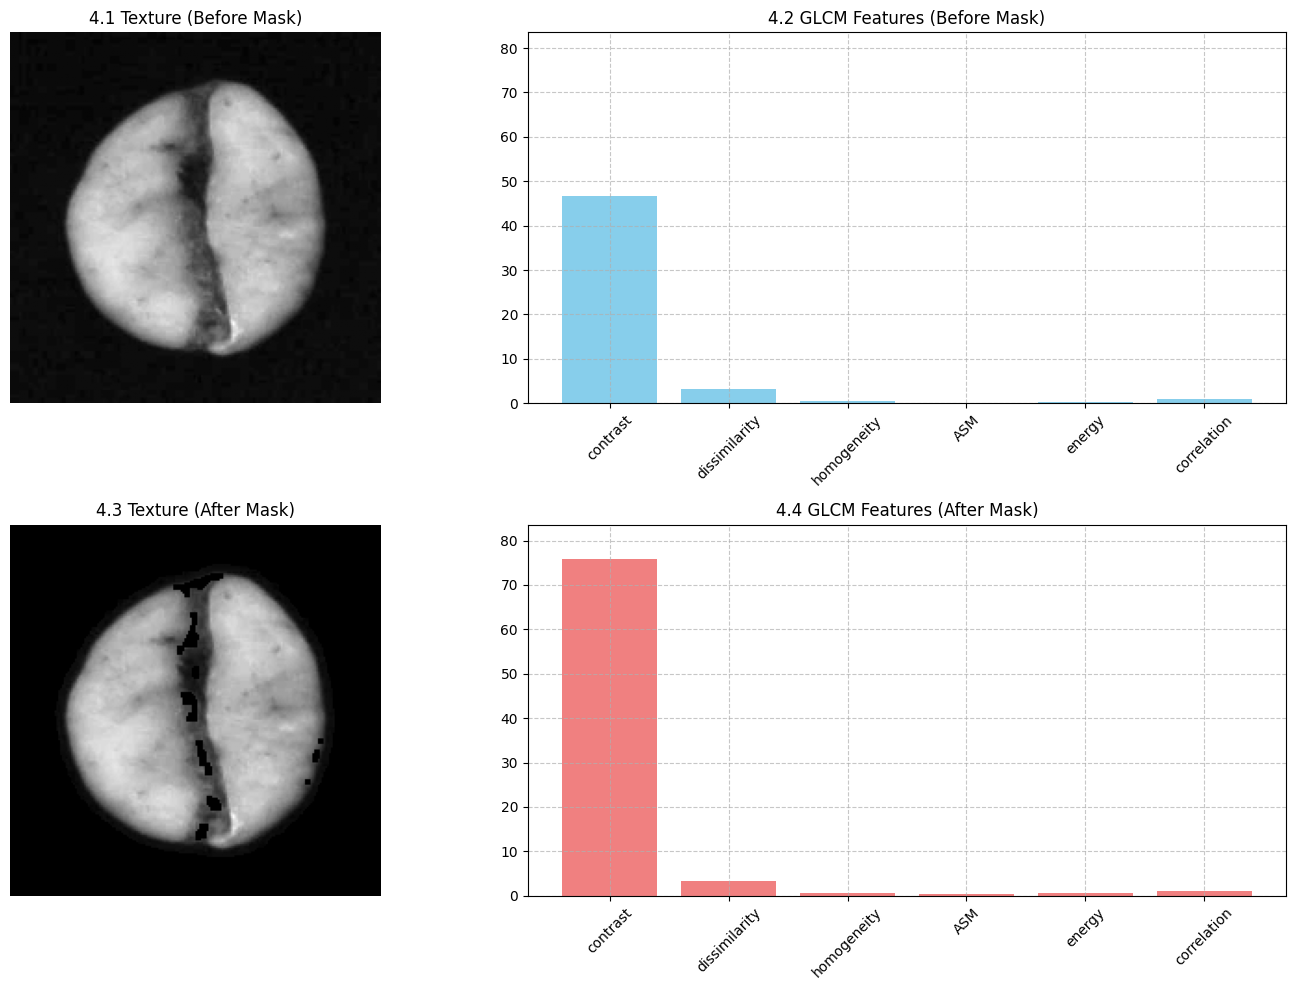

In [7]:
texture_before = prepare_texture_image(gray_no_blur, mask=None)
glcm_before = graycomatrix(texture_before, distances=[1], angles=[0],
                           levels=256, symmetric=True, normed=True)

# Extract GLCM properties for before mask
contrast_before = graycoprops(glcm_before, 'contrast')[0,0]
dissimilarity_before = graycoprops(glcm_before, 'dissimilarity')[0,0]
homogeneity_before = graycoprops(glcm_before, 'homogeneity')[0,0]
ASM_before = graycoprops(glcm_before, 'ASM')[0,0]
energy_before = graycoprops(glcm_before, 'energy')[0,0]
correlation_before = graycoprops(glcm_before, 'correlation')[0,0]

texture_after = prepare_texture_image(gray_no_blur, opened_blur)  # Using blurred mask
glcm_after = graycomatrix(texture_after, distances=[1], angles=[0],
                          levels=256, symmetric=True, normed=True)

# Extract GLCM properties for after mask
contrast_after = graycoprops(glcm_after, 'contrast')[0,0]
dissimilarity_after = graycoprops(glcm_after, 'dissimilarity')[0,0]
homogeneity_after = graycoprops(glcm_after, 'homogeneity')[0,0]
ASM_after = graycoprops(glcm_after, 'ASM')[0,0]
energy_after = graycoprops(glcm_after, 'energy')[0,0]
correlation_after = graycoprops(glcm_after, 'correlation')[0,0]

# Create figure with 2x2 subplots
plt.figure(figsize=(15, 10))

# Plot texture images
plt.subplot(2, 2, 1)
plt.imshow(texture_before, cmap='gray')
plt.title("4.1 Texture (Before Mask)")
plt.axis("off")

# Plot GLCM features before mask
plt.subplot(2, 2, 2)
features_before = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
values_before = [contrast_before, dissimilarity_before, homogeneity_before, 
                ASM_before, energy_before, correlation_before]
plt.bar(features_before, values_before, color='skyblue')
plt.title("4.2 GLCM Features (Before Mask)")
plt.xticks(rotation=45)
plt.ylim(0, max(max(values_before), max([contrast_after, dissimilarity_after, 
         homogeneity_after, ASM_after, energy_after, correlation_after])) * 1.1)
plt.grid(True, linestyle='--', alpha=0.7)

# Plot texture after mask
plt.subplot(2, 2, 3)
plt.imshow(texture_after, cmap='gray')
plt.title("4.3 Texture (After Mask)")
plt.axis("off")

# Plot GLCM features after mask
plt.subplot(2, 2, 4)
features_after = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
values_after = [contrast_after, dissimilarity_after, homogeneity_after, 
               ASM_after, energy_after, correlation_after]
plt.bar(features_after, values_after, color='lightcoral')
plt.title("4.4 GLCM Features (After Mask)")
plt.xticks(rotation=45)
plt.ylim(0, max(max(values_before), max(values_after)) * 1.1)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

cell 3.9 pendefinisian hasil dari extract features hsv warna dan glcm texture

In [8]:
def extract_features(segmented_mask, original_image):
    segmented_mask = cv2.resize(segmented_mask, (original_image.shape[1], original_image.shape[0]))
    
    masked_image = cv2.bitwise_and(original_image, original_image, mask=segmented_mask)

    hsv_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)
    mean_h = np.mean(h[segmented_mask > 0])
    mean_s = np.mean(s[segmented_mask > 0])
    mean_v = np.mean(v[segmented_mask > 0])
    hsv_features = [mean_h, mean_s, mean_v]

    gray_masked = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    gray_masked[segmented_mask == 0] = 0
    glcm = graycomatrix(gray_masked, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0,0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0,0]
    energy = graycoprops(glcm, 'energy')[0,0]
    correlation = graycoprops(glcm, 'correlation')[0,0]
    texture_features = [contrast, homogeneity, energy, correlation]

    features = hsv_features + texture_features
    return features

cell 4 buat training, dataset di seimbangkan dengan emnyamakan semua jumlah image setiap kelas yang ada dengan kelas yg paling dikit

Loading unbalanced datasets with blur for segmentation...
Robusta: 1622 samples (using all)
Arabika: 5212 samples (using all)
Liberika: 402 samples (using all)
Arabika: 662 samples (using all)
Robusta: 205 samples (using all)
Liberika: 51 samples (using all)
Arabika: 659 samples (using all)
Robusta: 208 samples (using all)
Liberika: 51 samples (using all)

Unbalanced class distribution:
Train: Counter({'Arabika': 5212, 'Robusta': 1622, 'Liberika': 402})
Valid: Counter({'Arabika': 662, 'Robusta': 205, 'Liberika': 51})
Test: Counter({'Arabika': 659, 'Robusta': 208, 'Liberika': 51})

Unbalanced dataset shapes:
Train: (7236, 7)
Valid: (918, 7)
Test: (918, 7)

Training set distribution:
Robusta: 1622 samples (22.4%)
Arabika: 5212 samples (72.0%)
Liberika: 402 samples (5.6%)

Validation set distribution:
Arabika: 662 samples (72.1%)
Robusta: 205 samples (22.3%)
Liberika: 51 samples (5.6%)

Test set distribution:
Arabika: 659 samples (71.8%)
Robusta: 208 samples (22.7%)
Liberika: 51 samples (

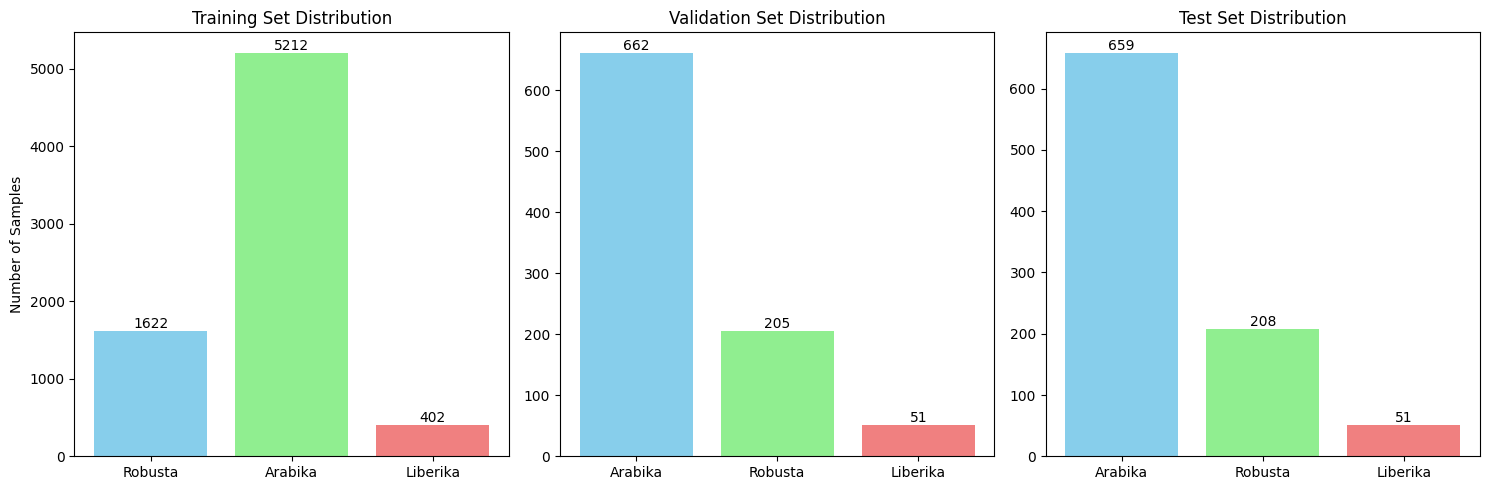

In [9]:
def load_dataset_unbalanced(folder):
    df = pd.read_csv(os.path.join(folder, '_classes.csv'))
    data_per_class = defaultdict(list)

    for _, row in df.iterrows():
        img_path = os.path.join(folder, row['filename'])
        img = cv2.imread(img_path)

        if img is None:
            print(f"Skipping {row['filename']} karena tidak bisa dibaca.")
            continue

        # Use blur for segmentation (better mask)
        gray = preprocess(img, use_blur=True)
        _, _, final_mask = segment(gray)
        
        feats = extract_features(final_mask, img)

        if feats is not None:
            label_col = row.index[1:]
            label_val = row.iloc[1:]
            label = label_col[label_val == 1].values[0]
            data_per_class[label].append((feats, label))

    # Use all samples without balancing
    X, y = [], []
    for label, samples in data_per_class.items():
        print(f"{label}: {len(samples)} samples (using all)")
        for feat, label in samples:
            X.append(feat)
            y.append(label)

    return np.array(X), np.array(y)

print("Loading unbalanced datasets with blur for segmentation...")
X_train, y_train = load_dataset_unbalanced("train")
X_valid, y_valid = load_dataset_unbalanced("valid")
X_test, y_test = load_dataset_unbalanced("test")

import collections
print("\nUnbalanced class distribution:")
print("Train:", collections.Counter(y_train))
print("Valid:", collections.Counter(y_valid))
print("Test:", collections.Counter(y_test))

print(f"\nUnbalanced dataset shapes:")
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

# Show class distribution percentages
def print_distribution(y, set_name):
    total = len(y)
    counter = collections.Counter(y)
    print(f"\n{set_name} set distribution:")
    for label, count in counter.items():
        percentage = (count / total) * 100
        print(f"{label}: {count} samples ({percentage:.1f}%)")

print_distribution(y_train, "Training")
print_distribution(y_valid, "Validation")
print_distribution(y_test, "Test")

# Visualize class distribution
plt.figure(figsize=(15, 5))

# Training set distribution
plt.subplot(1, 3, 1)
train_counts = collections.Counter(y_train)
plt.bar(train_counts.keys(), train_counts.values(), color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Training Set Distribution')
plt.ylabel('Number of Samples')
for i, v in enumerate(train_counts.values()):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Validation set distribution
plt.subplot(1, 3, 2)
valid_counts = collections.Counter(y_valid)
plt.bar(valid_counts.keys(), valid_counts.values(), color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Validation Set Distribution')
for i, v in enumerate(valid_counts.values()):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Test set distribution
plt.subplot(1, 3, 3)
test_counts = collections.Counter(y_test)
plt.bar(test_counts.keys(), test_counts.values(), color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Test Set Distribution')
for i, v in enumerate(test_counts.values()):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

cell 5

In [10]:
warnings.filterwarnings('ignore')

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_valid_enc = le.transform(y_valid)
y_test_enc = le.transform(y_test)

# Adjust class weights based on sample distribution
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train_enc), class_weights))

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=200, 
        max_depth=15, 
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42, 
        class_weight='balanced',
        n_jobs=-1
    ),
    'Extra Trees': ExtraTreesClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=8,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=7,
        weights='distance',
        metric='minkowski',
        p=2
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced'
    ),
    'Gaussian Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(
        C=1.0,
        random_state=42,
        class_weight='balanced',
        max_iter=1000,
        solver='liblinear'
    ),
    'SVM': SVC(
        C=100,
        gamma='scale',
        kernel='rbf',
        probability=True,
        class_weight='balanced',
        random_state=42
    )
}

results = {}
best_model = None
best_accuracy = 0

print("Training and evaluating multiple models with unbalanced data...")
print("=" * 70)

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    if name != 'Gaussian Naive Bayes':
        pipeline = make_pipeline(StandardScaler(), model)
    else:
        pipeline = model
    
    pipeline.fit(X_train, y_train_enc)
    
    y_valid_pred = pipeline.predict(X_valid)
    valid_accuracy = accuracy_score(y_valid_enc, y_valid_pred)
    
    y_test_pred = pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test_enc, y_test_pred)
    
    results[name] = {
        'model': pipeline,
        'valid_accuracy': valid_accuracy,
        'test_accuracy': test_accuracy,
        'y_test_pred': y_test_pred
    }
    
    print(f"{name}:")
    print(f"  Validation Accuracy: {valid_accuracy:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}")
    
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = name

print("\n" + "=" * 70)
print(f"Best Model: {best_model} with Test Accuracy: {best_accuracy:.4f}")
print("=" * 70)

best_pipeline = results[best_model]['model']
joblib.dump(best_pipeline, "best_coffee_classifier_unbalanced.pkl")
joblib.dump(le, "label_encoder_unbalanced.pkl")
print(f"\nBest model ({best_model}) saved as 'best_coffee_classifier_unbalanced.pkl'")

Training and evaluating multiple models with unbalanced data...

Training Random Forest...
Random Forest:
  Validation Accuracy: 0.8551
  Test Accuracy: 0.8420

Training Extra Trees...
Extra Trees:
  Validation Accuracy: 0.8257
  Test Accuracy: 0.8039

Training Gradient Boosting...
Gradient Boosting:
  Validation Accuracy: 0.8584
  Test Accuracy: 0.8475

Training K-Nearest Neighbors...
K-Nearest Neighbors:
  Validation Accuracy: 0.8595
  Test Accuracy: 0.8682

Training Decision Tree...
Decision Tree:
  Validation Accuracy: 0.7647
  Test Accuracy: 0.7538

Training Gaussian Naive Bayes...
Gaussian Naive Bayes:
  Validation Accuracy: 0.6917
  Test Accuracy: 0.6928

Training Logistic Regression...
Logistic Regression:
  Validation Accuracy: 0.7298
  Test Accuracy: 0.7364

Training SVM...
SVM:
  Validation Accuracy: 0.8290
  Test Accuracy: 0.8355

Best Model: K-Nearest Neighbors with Test Accuracy: 0.8682

Best model (K-Nearest Neighbors) saved as 'best_coffee_classifier_unbalanced.pkl'


cell 6 buat nampilin hasil training nya

DETAILED RESULTS FOR ALL MODELS (UNBALANCED DATA)

RANDOM FOREST
----------------------------------------
Validation Accuracy: 0.8551
Test Accuracy: 0.8420

Classification Report (Test Set):
              precision    recall  f1-score   support

     Arabika       0.91      0.88      0.90       659
    Liberika       0.78      0.69      0.73        51
     Robusta       0.67      0.75      0.71       208

    accuracy                           0.84       918
   macro avg       0.79      0.77      0.78       918
weighted avg       0.85      0.84      0.84       918


EXTRA TREES
----------------------------------------
Validation Accuracy: 0.8257
Test Accuracy: 0.8039

Classification Report (Test Set):
              precision    recall  f1-score   support

     Arabika       0.94      0.80      0.87       659
    Liberika       0.64      0.69      0.66        51
     Robusta       0.58      0.84      0.68       208

    accuracy                           0.80       918
   macro avg     

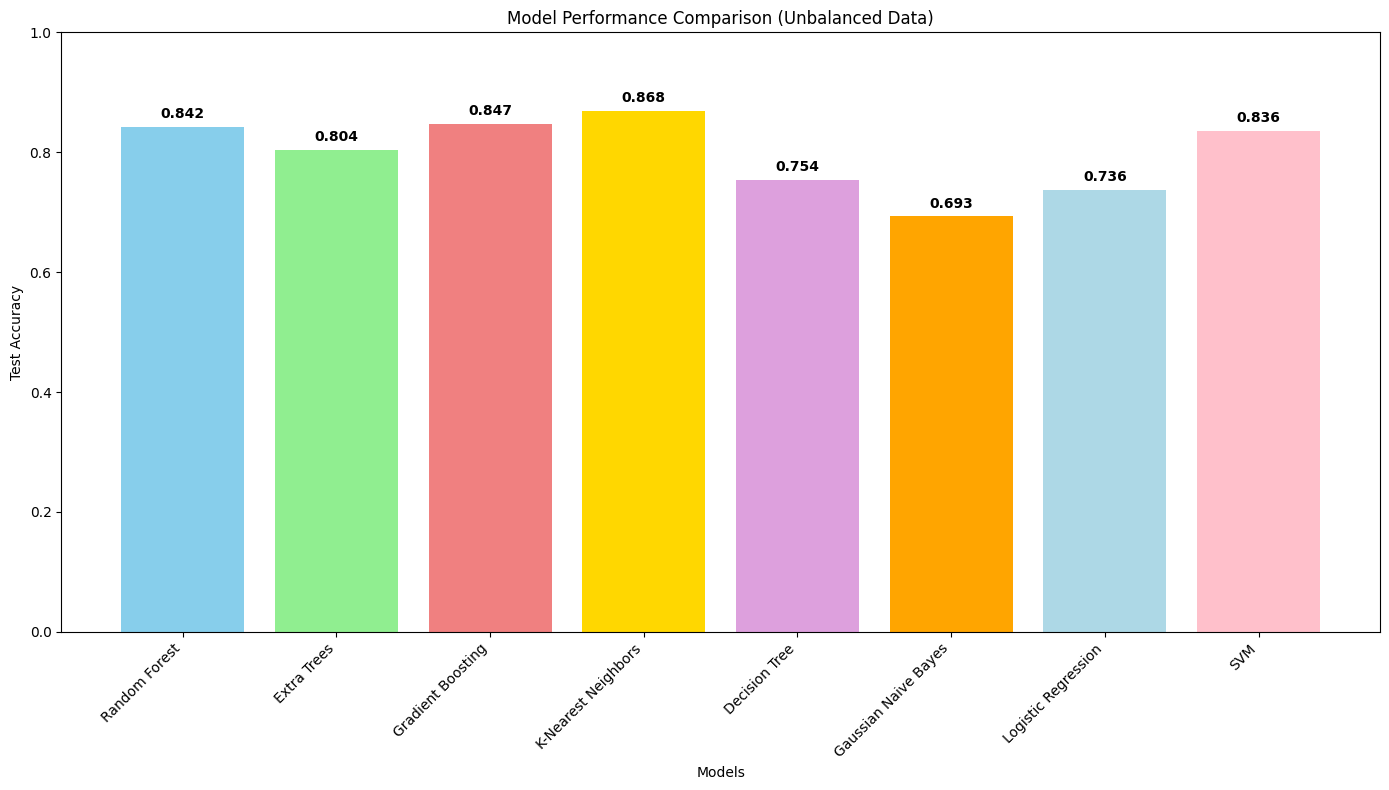


Improvement Analysis:
Best accuracy with unbalanced data: 0.8682
Previous balanced accuracy: 0.8170
Difference: 0.0512


In [11]:
print("DETAILED RESULTS FOR ALL MODELS (UNBALANCED DATA)")
print("=" * 80)

for name, result in results.items():
    print(f"\n{name.upper()}")
    print("-" * 40)
    print(f"Validation Accuracy: {result['valid_accuracy']:.4f}")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test_enc, result['y_test_pred'], target_names=le.classes_))

print("\n" + "=" * 80)
print(f"BEST MODEL: {best_model}")
print("=" * 80)
best_result = results[best_model]
print(classification_report(y_test_enc, best_result['y_test_pred'], target_names=le.classes_))

model_names = list(results.keys())
test_accuracies = [results[name]['test_accuracy'] for name in model_names]

plt.figure(figsize=(14, 8))
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum', 'orange', 'lightblue', 'pink']
bars = plt.bar(model_names, test_accuracies, color=colors[:len(model_names)])
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Model Performance Comparison (Unbalanced Data)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

for bar, acc in zip(bars, test_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nImprovement Analysis:")
print(f"Best accuracy with unbalanced data: {best_accuracy:.4f}")
print(f"Previous balanced accuracy: 0.8170")
print(f"Difference: {best_accuracy - 0.8170:.4f}")

cell 7 save hasil model ama labelnya pake formatnya pkl biar gampang

In [12]:
# #save semua modelnya selain best model
# for name, result in results.items():
#     safe_name = name.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_')
#     joblib.dump(result['model'], f"coffee_classifier_{safe_name}.pkl")

# print("All models saved:")
# for name in results.keys():
#     safe_name = name.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_')
#     print(f"- coffee_classifier_{safe_name}.pkl")

# print(f"\nBest model ({best_model}) saved as 'best_coffee_classifier.pkl'")
# print("Label encoder saved as 'label_encoder.pkl'")

cell 8 buat testing, testingnya udah di pisahin dan di taro di 3 folder "randomtest*", keluarkan salah satu gambar ke root untuk nge test gambar tersebut

klo mau langsung jalanin testing nya aja menggunakan model .pkl nya, pastiin udah run import libraries nya dulu di cel 1 (paling atas)

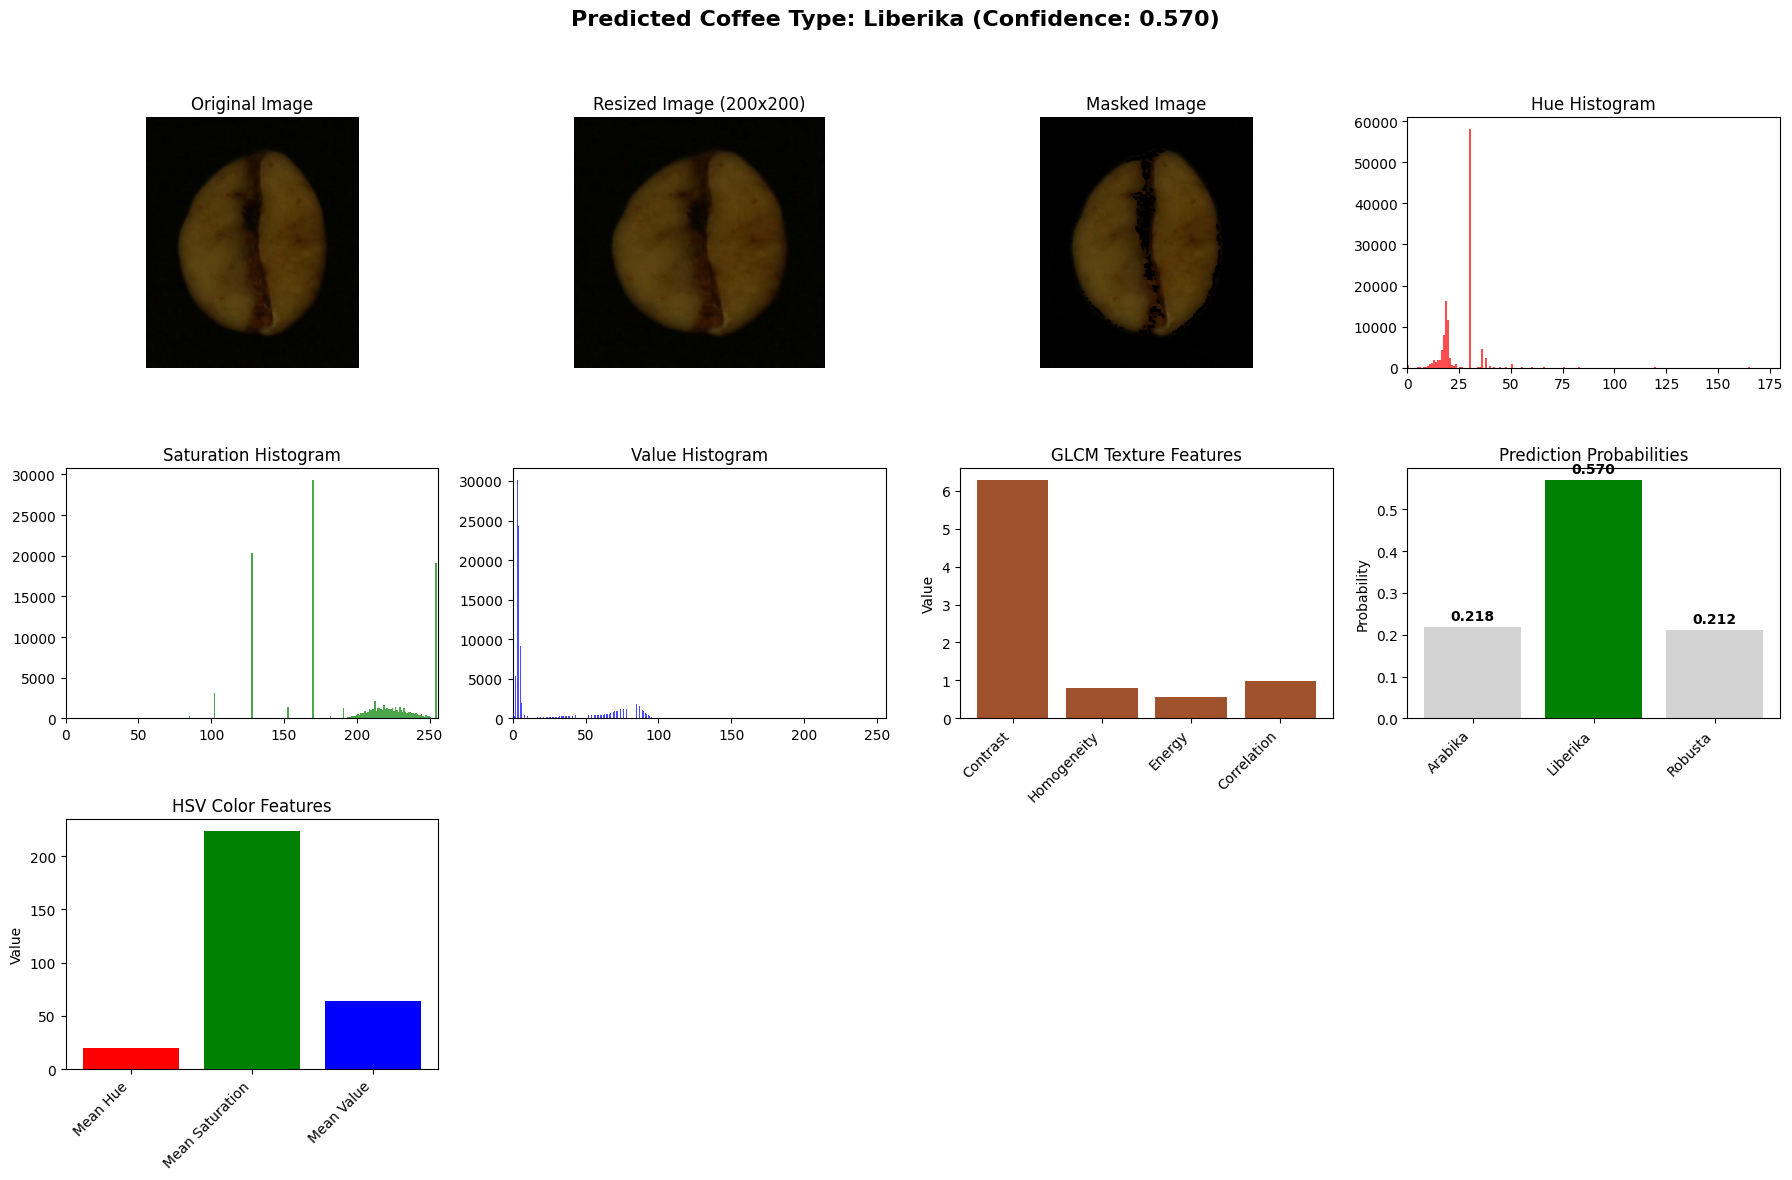

Predicted: Liberika
Probabilities:
  Arabika: 0.218
  Liberika: 0.570
  Robusta: 0.212


In [13]:
best_pipeline = joblib.load("best_coffee_classifier.pkl")
le = joblib.load("label_encoder.pkl")

def predict_single_image_enhanced(image_path, pipeline, le):
    img = cv2.imread(image_path)
    if img is None:
        print("Gambar tidak bisa dibaca.")
        return

    gray = preprocess(img)
    _, _, mask = segment(gray)
    masked_image = apply_mask(img, mask)

    feats = extract_features(mask, img)
    if feats is None:
        print("Gagal ekstrak fitur, coba gambar lain.")
        return

    feats = np.array(feats).reshape(1, -1)
    pred_enc = pipeline.predict(feats)
    pred_label = le.inverse_transform(pred_enc)[0]
    
    if hasattr(pipeline, 'predict_proba'):
        proba = pipeline.predict_proba(feats)[0]
        proba_dict = dict(zip(le.classes_, proba))
    else:
        proba_dict = {pred_label: 1.0}

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    fig = plt.figure(figsize=(18, 12))

    ax1 = fig.add_subplot(3, 4, 1)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title("Original Image")
    ax1.axis('off')

    ax2 = fig.add_subplot(3, 4, 2)
    resized = cv2.resize(img, (200, 200))
    ax2.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
    ax2.set_title("Resized Image (200x200)")
    ax2.axis('off')

    ax3 = fig.add_subplot(3, 4, 3)
    ax3.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
    ax3.set_title("Masked Image")
    ax3.axis('off')

    ax4 = fig.add_subplot(3, 4, 4)
    ax4.hist(h.ravel(), bins=180, color='r', alpha=0.7)
    ax4.set_title("Hue Histogram")
    ax4.set_xlim([0, 180])

    ax5 = fig.add_subplot(3, 4, 5)
    ax5.hist(s.ravel(), bins=256, color='g', alpha=0.7)
    ax5.set_title("Saturation Histogram")
    ax5.set_xlim([0, 256])

    ax6 = fig.add_subplot(3, 4, 6)
    ax6.hist(v.ravel(), bins=256, color='b', alpha=0.7)
    ax6.set_title("Value Histogram")
    ax6.set_xlim([0, 256])

    ax7 = fig.add_subplot(3, 4, 7)
    texture_names = ['Contrast', 'Homogeneity', 'Energy', 'Correlation']
    texture_values = feats.flatten()[-4:]
    bars = ax7.bar(texture_names, texture_values, color='sienna')
    ax7.set_title("GLCM Texture Features")
    ax7.set_ylabel("Value")
    plt.setp(ax7.xaxis.get_majorticklabels(), rotation=45, ha='right')

    ax8 = fig.add_subplot(3, 4, 8)
    classes = list(proba_dict.keys())
    probabilities = list(proba_dict.values())
    colors = ['green' if c == pred_label else 'lightgray' for c in classes]
    bars = ax8.bar(classes, probabilities, color=colors)
    ax8.set_title("Prediction Probabilities")
    ax8.set_ylabel("Probability")
    plt.setp(ax8.xaxis.get_majorticklabels(), rotation=45, ha='right')

    for bar, prob in zip(bars, probabilities):
        ax8.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')

    ax9 = fig.add_subplot(3, 4, 9)
    hsv_features = feats.flatten()[:3]
    hsv_names = ['Mean Hue', 'Mean Saturation', 'Mean Value']
    bars = ax9.bar(hsv_names, hsv_features, color=['red', 'green', 'blue'])
    ax9.set_title("HSV Color Features")
    ax9.set_ylabel("Value")
    plt.setp(ax9.xaxis.get_majorticklabels(), rotation=45, ha='right')

    if hasattr(pipeline, 'named_steps') and 'randomforestclassifier' in str(pipeline.named_steps).lower():
        try:
            rf_model = pipeline.named_steps['randomforestclassifier']
            if hasattr(rf_model, 'feature_importances_'):
                ax10 = fig.add_subplot(3, 4, 10)
                feature_names = ['Hue', 'Saturation', 'Value', 'Contrast', 'Homogeneity', 'Energy', 'Correlation']
                importances = rf_model.feature_importances_
                bars = ax10.bar(feature_names, importances, color='purple')
                ax10.set_title("Feature Importance")
                ax10.set_ylabel("Importance")
                plt.setp(ax10.xaxis.get_majorticklabels(), rotation=45, ha='right')
        except:
            pass

    fig.suptitle(f"Predicted Coffee Type: {pred_label} (Confidence: {proba_dict[pred_label]:.3f})", 
                 fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print(f"Predicted: {pred_label}")
    print("Probabilities:")
    for class_name, prob in proba_dict.items():
        print(f"  {class_name}: {prob:.3f}")

image_paths = glob.glob("coba*.jpg")
if image_paths:
    predict_single_image_enhanced(image_paths[0], best_pipeline, le)
else:
    print("Tidak ditemukan gambar yang cocok dengan pola 'coba*.jpg'")

cell 9 buat ngecheck tabel evaluasinya

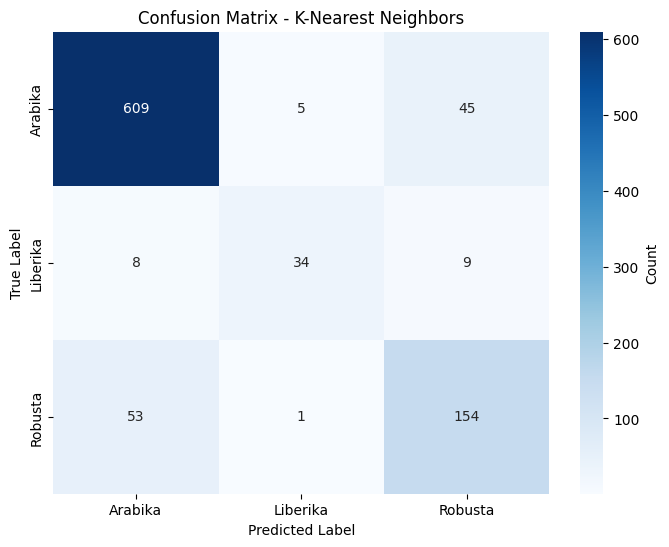

Detailed Evaluation Results:
      Class   TP  FP  FN   TN  Precision  Recall  F1-Score
0   Arabika  609  61  50  198      0.909   0.924     0.916
1  Liberika   34   6  17  861      0.850   0.667     0.747
2   Robusta  154  54  54  656      0.740   0.740     0.740

Overall Accuracy: 0.8682

Best Model: K-Nearest Neighbors
Test Accuracy: 0.8682


In [15]:
best_pipeline = joblib.load("best_coffee_classifier_unbalanced.pkl")
le = joblib.load("label_encoder_unbalanced.pkl")

y_test_enc = le.transform(y_test)
y_pred_enc = best_pipeline.predict(X_test)

cm = confusion_matrix(y_test_enc, y_pred_enc)
labels = le.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, 
            cmap='Blues', cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - {best_model}')
plt.show()

confusion_table = []

for i, label in enumerate(labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    confusion_table.append({
        'Class': label,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

df_confusion = pd.DataFrame(confusion_table)
print("Detailed Evaluation Results:")
print(df_confusion.round(3))

overall_accuracy = accuracy_score(y_test_enc, y_pred_enc)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

print(f"\nBest Model: {best_model}")
print(f"Test Accuracy: {overall_accuracy:.4f}")